In [1]:
%matplotlib notebook
# We start off with the baseline import statements we need to do the basic data manipulation and visualization.
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

import matplotlib.pyplot as plt
import calendar
from sklearn.ensemble import RandomForestClassifier

sns.set_style("whitegrid")

#We create and set aside a copy of the data for initial exploration
housing_train = pd.read_csv('../data/train.csv')
housing = housing_train.copy()

#MISSING DATA
total = housing.isnull().sum().sort_values(ascending=False)
percent = (housing.isnull().sum()/housing.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

#CORRELATION CHECK
corr_matrix = housing.corr()
top_corr = corr_matrix['SalePrice'].sort_values(ascending = False)

top_corr

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

In [2]:
#DROPPING SOME COLUMNS
drop = ['PoolQC', 'PoolArea','MiscFeature', 'MiscVal', 'Alley', 'Fence', 'FireplaceQu', 'Fireplaces', 'LotFrontage']
drop2 = ['Id','GarageArea','1stFlrSF','GarageYrBlt','MSSubClass'] 
housing.drop(columns = drop + drop2, inplace = True)
housing['Age'] = housing['YrSold'] - housing['YearBuilt']
housing['AgeRemodel'] = housing['YrSold'] - housing['YearRemodAdd']
housing = housing[housing.AgeRemodel >= 0]
housing = housing[housing.GrLivArea < 4000]
housing.drop(columns = ['YearBuilt','YearRemodAdd'], inplace = True)

housing.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1459
Data columns (total 67 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1456 non-null   object 
 1   LotArea        1456 non-null   int64  
 2   Street         1456 non-null   object 
 3   LotShape       1456 non-null   object 
 4   LandContour    1456 non-null   object 
 5   Utilities      1456 non-null   object 
 6   LotConfig      1456 non-null   object 
 7   LandSlope      1456 non-null   object 
 8   Neighborhood   1456 non-null   object 
 9   Condition1     1456 non-null   object 
 10  Condition2     1456 non-null   object 
 11  BldgType       1456 non-null   object 
 12  HouseStyle     1456 non-null   object 
 13  OverallQual    1456 non-null   int64  
 14  OverallCond    1456 non-null   int64  
 15  RoofStyle      1456 non-null   object 
 16  RoofMatl       1456 non-null   object 
 17  Exterior1st    1456 non-null   object 
 18  Exterior

In [3]:
#FURTHER DATA CLEANING
housing_cat = housing.select_dtypes(exclude=[np.number])
housing_numeric = housing.select_dtypes(include=[np.number])

#Numeric
numeric_unbounded = ['LotArea', 'MasVnrArea','BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF',
                     'TotalBsmtSF','2ndFlrSF','LowQualFinSF','GrLivArea','WoodDeckSF',
                     'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch', 'SalePrice',
                     'Age','AgeRemodel']

#numeric_one_hot = ['MSSubClass','MoSold']
numeric_one_hot = ['MoSold']
numeric_ordinal = [x for x in housing_numeric.columns 
                   if (x not in numeric_unbounded and x not in numeric_one_hot)]

housing_numeric_unbounded = housing_numeric[numeric_unbounded]
housing_numeric_one_hot = housing_numeric[numeric_one_hot]
housing_numeric_ordinal = housing_numeric[numeric_ordinal]

#housing_numeric_one_hot['MSSubClass'] = housing_numeric_one_hot['MSSubClass'].astype('str')
housing_numeric_one_hot['MoSold'] = housing_numeric_one_hot['MoSold'].replace({i:calendar.month_name[i][:3] for i in range(1,13)})
housing_numeric_one_hot = pd.get_dummies(housing_numeric_one_hot)
#Categorical
cat_ordinal = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
               'BsmtFinType1', 'HeatingQC', 'KitchenQual','Functional','GarageFinish',
               'GarageQual', 'GarageCond']

housing_cat_ordinal = housing_cat[cat_ordinal]
housing_cat_ordinal.fillna('No', inplace = True)
housing_cat_one_hot = housing_cat.drop(columns = cat_ordinal)

housing_cat_one_hot = pd.get_dummies(housing_cat_one_hot)

def mapper(cat):
    if cat in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
               'HeatingQC', 'KitchenQual']:
        mapper = {'No':0, 'Po':1, 'Fa':2,'TA':3,'Gd':4,'Ex':5}
    elif cat == 'BsmtExposure':
            mapper = {'No':0,'No':1, 'Mn':2, 'Av':3,'Gd':4}
    elif cat == 'BsmtFinType1':
        mapper = {'No':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6}
    elif cat == 'Functional':
        mapper = {'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5, 'Min1':6,'Typ':7}
    else:
        mapper = {'No':0,'Unf':1,'RFn':2,'Fin':3}
        
    return mapper

for cat in cat_ordinal:
    housing_cat_ordinal[cat].replace(mapper(cat), inplace = True)

#Combining numeric and categorical
housing_ordinal = pd.concat([housing_numeric_ordinal,housing_cat_ordinal], axis = 'columns')
housing_one_hot = pd.concat([housing_numeric_one_hot, housing_cat_one_hot], axis = 'columns')
housing_clean = pd.concat([housing_one_hot, housing_ordinal, housing_numeric_unbounded], 
                          axis = 'columns')
#Getting rid of skew
skewed_feats = housing_clean[numeric_unbounded].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

housing_clean[skewed_feats] = np.log1p(housing_clean[skewed_feats])

#MORE CORRELATION
ordinal_prices = pd.concat([housing_ordinal, housing['SalePrice']], axis = 'columns')
ordinal_corr_matrix = ordinal_prices.corr()
top_corr_ordinal = ordinal_corr_matrix['SalePrice'].sort_values(ascending = False)

one_hot_prices = pd.concat([housing_one_hot, housing['SalePrice']], axis = 'columns')
one_hot_corr_matrix = one_hot_prices.corr()
top_corr_one_hot = one_hot_corr_matrix['SalePrice'].filter(like = 'Neighborhood').sort_values(ascending = False)

<ipython-input-3-0ef994b6d77d>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_numeric_one_hot['MoSold'] = housing_numeric_one_hot['MoSold'].replace({i:calendar.month_name[i][:3] for i in range(1,13)})
C:\Users\abrah\anaconda3\envs\quantum_ML\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\abrah\anaconda3\envs\quantum_ML\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

In [4]:
#REMOVAL OF THE REMAINING NaN
housing_clean.isnull().sum().sort_values(ascending=False)
df = housing_clean.copy()
problem_col = df.isin([np.nan, np.inf, -np.inf]).sum(axis=0)[df.isin([np.nan, np.inf, -np.inf]).sum(axis=0) != 0] 
index_to_drop = df[problem_col.index[0]][df[problem_col.index[0]].isin([np.nan, np.inf, -np.inf])].index
df.drop(index = index_to_drop, inplace = True)
df.isnull().sum().sort_values(ascending=False)

MoSold_Apr          0
Foundation_Stone    0
BsmtFinType2_ALQ    0
BsmtFinType2_BLQ    0
BsmtFinType2_GLQ    0
                   ..
BldgType_2fmCon     0
BldgType_Duplex     0
BldgType_Twnhs      0
BldgType_TwnhsE     0
AgeRemodel          0
Length: 229, dtype: int64

In [5]:
#RANDOM FOREST FOR FEATURE IMPORTANCE
X_train = df.drop(columns = ['SalePrice'])
y_train = df['SalePrice']

forest = RandomForestClassifier(n_estimators=500, max_depth=4)

forest.fit(X_train, y_train)

forest.feature_importances_
score_df = pd.DataFrame({'feature':X_train.columns,
                            'importance_score': forest.feature_importances_})

ValueError: Unknown label type: 'continuous'

In [ ]:
#We will look at feature importances and their correlation with the 'SalePrice'
score_df.sort_values('feature', inplace=True)
top_corr = df.corr()['SalePrice'].abs().drop(index = ['SalePrice']) #I suppose we want to look at the absolute value
                                                                    #of the correlation. Is that right?
top_corr.sort_index(inplace=True) 
#now rows of score_df and top_corr match and we can add the values of correlation
score_df['correlation'] = top_corr.values

In [ ]:
score_df.sort_values(ascending=False, by = ['importance_score'], inplace = True)
score_df['importance_score_rank'] = [k for k in range(1,1+len(score_df.index))]
score_df.sort_values(ascending=False, by = ['correlation'], inplace = True)
score_df['correlation_rank'] = [k for k in range(1,1+len(score_df.index))]
score_df['overall_rank'] = (score_df['importance_score_rank'] + score_df['correlation_rank'])/2 
score_df.sort_values(ascending=True, by = ['overall_rank'], inplace = True)
score_df.reset_index(drop = True, inplace = True)
score_df.head(20)

Correlation measures only linear dependence between variables and it does not detect non-linear dependence (in particular cor(X,Y) can be 0 for random variables X and Y=X^2, which are of course completely dependent). So, if a given feature has high feature_importance score, but low correlation it means that 'SalePrice' depend on it in a non-linear manner.

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(score_df['importance_score_rank'][:20], score_df['correlation_rank'][:20], c ="blue",
            linewidths = 1)
plt.title('importance_rank vs correlation_rank')
plt.xticks(np.arange(0, 40, step=1))
plt.yticks(np.arange(0, 40, step=1))
plt.xlabel("importance_score_rank")
plt.ylabel("correlation_rank")
plt.show()

## Using Linear Regression models to predict housing prices
Below, we compare several candidate models to predict the housing prices. We will compare the baselined model of sale price average along with ordinary least squares, ridge regression, lasso regression, and elastic net regression. We will be operating with log housing prices to combat heteroscedasticity.

### Ordinary Least Squares Regression Coefficients blow up due to collinearity in categorical data
One weird thing is that the ordinary Least Squares Regression Coefficients are on radically different scales from one another. We see very negative coefficients along with very large positive coefficients. We make some plots of the scales of the regression coefficients below. We notice that the scales of the categorical variables seem to be much greater than those of the unbounded or the ordinal variables. Ordinary Least Squares is ill fit to deal with the multicollinearity of these categorical variables. This is taken care of via regularization which limits the size of the coefficients. We'll describe regularization later. OLS blowup can be mitigated by dummy encoding the variables instead of one-hot but I was still having collinearity problems on cross validation for the dummy encoding.

In [6]:
#We scale all the data note X_train and y_train are fairly clean
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
X = df.drop(columns = 'SalePrice')
y = (df['SalePrice'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 20)

#We call the standard Scaler object and fit it
scaler = StandardScaler()
scaler.fit(X_train)


#We work with the scaled training set and log prices
X_train = (scaler.transform(X_train))
X_test = (scaler.transform(X_test))

In [7]:
#Our baseline model looking at the average
y_pred_average = np.ones(len(y_test)) * np.mean(y_train)

In [8]:
#Our Simple Linear Regression Model
from sklearn.linear_model import LinearRegression
slr = LinearRegression(copy_X = True)
slr.fit(X_train, y_train)
y_pred_slr = (slr.predict(X_test))


In [9]:
#Comparison of the RMSE. It is huge on the new data but relatively good on the training set suggesting overfit
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred_average, squared = False))
print(mean_squared_error(y_train, (slr.predict(X_train)), squared = False))

print(mean_squared_error((y_test), (y_pred_slr), squared = False))

0.3930609975455443
0.09292450920322146
2663041089220.985


Here we record some of the blow up of the coefficients

In [10]:
#Dataframe showing which coefficients correspond
print('Linear Regression Coefficients')
slr_coefficients = pd.DataFrame(slr.coef_.reshape(1,-1), columns = X.columns)
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
print_full(slr_coefficients.T[0].sort_values(ascending = False))

Linear Regression Coefficients
LandSlope_Gtl            2.241496e+12
LandSlope_Mod            2.098791e+12
Exterior1st_AsphShn      1.244204e+12
Condition2_PosN          1.181170e+12
BldgType_1Fam            1.035683e+12
Condition2_Norm          9.271487e+11
LandSlope_Sev            8.265702e+11
BldgType_TwnhsE          7.650127e+11
Condition2_Feedr         6.575550e+11
Utilities_NoSeWa         6.508021e+11
PavedDrive_Y             6.493882e+11
Exterior1st_VinylSd      6.330215e+11
Foundation_PConc         6.320444e+11
Foundation_CBlock        6.290062e+11
PavedDrive_N             5.580637e+11
BldgType_Duplex          5.396332e+11
Exterior2nd_VinylSd      5.280604e+11
Exterior1st_MetalSd      4.866272e+11
Exterior1st_HdBoard      4.817100e+11
SaleType_WD              4.742477e+11
Exterior1st_Wd Sdng      4.568117e+11
BldgType_Twnhs           4.351463e+11
Exterior2nd_MetalSd      4.068314e+11
Exterior2nd_HdBoard      3.973792e+11
SaleType_New             3.866613e+11
Foundation_BrkTil  

<IPython.core.display.Javascript object>


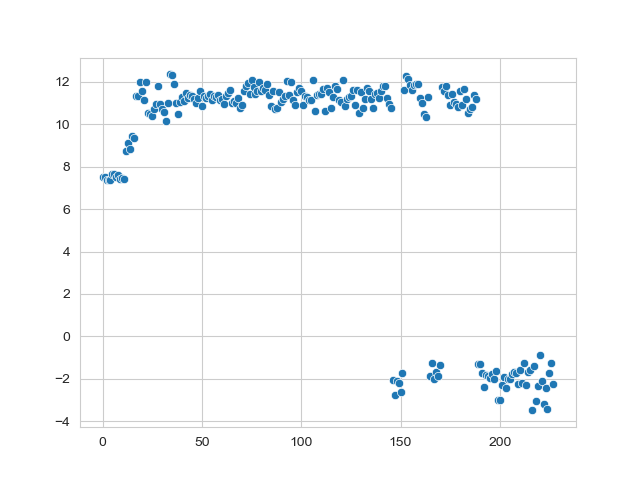

In [11]:
# A plot of the scales of the linear regression coefficients.
log_slr_coef = np.log10(np.abs(slr.coef_))

fig, ax = plt.subplots()
sns.scatterplot(data = log_slr_coef)
plt.show()


<IPython.core.display.Javascript object>


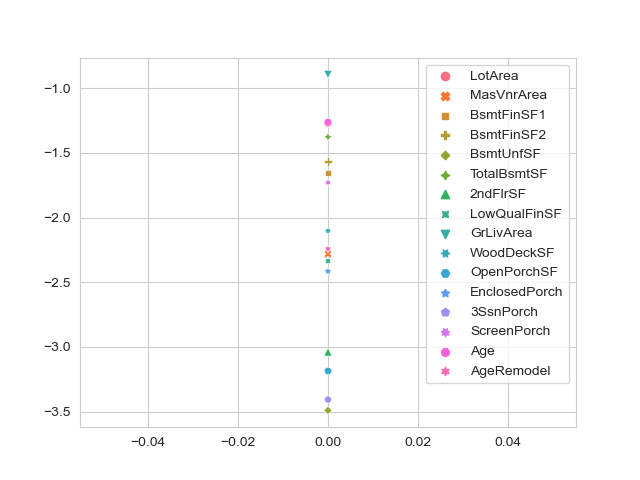

<IPython.core.display.Javascript object>


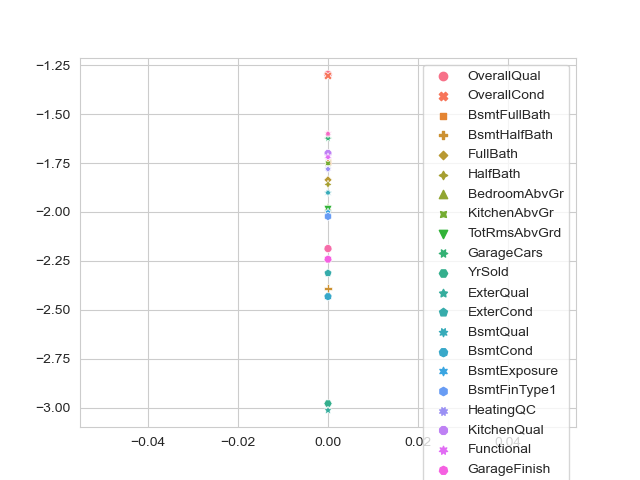

<AxesSubplot:>

In [12]:
#Plots of the unbounded and ordinal variable coefficient scales
numeric_train_unbounded = [x for x in numeric_unbounded if x != 'SalePrice']
log_coefs = np.log10(np.abs(slr_coefficients))
fig, ax = plt.subplots()
sns.scatterplot(data = log_coefs[numeric_train_unbounded])
fig, ax = plt.subplots()
sns.scatterplot(data = log_coefs[numeric_ordinal + cat_ordinal])


# Ordinary least squares on the numerical data
Instead we look at an OLS baseline for the numerical data, excluding the categorical variables.

In [13]:
X = df.drop(columns = 'SalePrice')
y = df['SalePrice']
numeric_train_unbounded = [x for x in numeric_unbounded if x!= 'SalePrice']
numeric_train = numeric_train_unbounded + numeric_ordinal + cat_ordinal

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 20)

#We call the standard Scaler object and fit it
X_train = X_train[numeric_train]
scaler = StandardScaler()
scaler.fit_transform(X_train)

slr = LinearRegression(copy_X = True)
slr.fit(X_train, y_train)
y_pred_slr = (slr.predict(X_train))

In [14]:
slr_coefficients = pd.DataFrame(slr.coef_.reshape(1,-1), columns = X_train.columns)
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
print_full(slr_coefficients.T[0].sort_values(ascending = False))

GrLivArea        0.445397
LotArea          0.091857
OverallQual      0.053227
OverallCond      0.053170
HalfBath         0.036986
GarageCars       0.036303
KitchenQual      0.036140
Functional       0.032021
ExterQual        0.031830
BsmtFullBath     0.028721
FullBath         0.027884
HeatingQC        0.019420
TotRmsAbvGrd     0.012158
BsmtHalfBath     0.011968
ScreenPorch      0.011921
BsmtQual         0.011421
GarageQual       0.010201
BsmtExposure     0.009377
GarageCond       0.009301
BsmtFinType1     0.002269
EnclosedPorch    0.001837
WoodDeckSF       0.000629
GarageFinish     0.000365
TotalBsmtSF      0.000106
BsmtFinSF1       0.000062
AgeRemodel      -0.000311
YrSold          -0.000342
BsmtFinSF2      -0.000673
MasVnrArea      -0.000896
Age             -0.002335
BsmtUnfSF       -0.002588
OpenPorchSF     -0.003161
2ndFlrSF        -0.006609
3SsnPorch       -0.008523
BsmtCond        -0.008598
LowQualFinSF    -0.009938
BedroomAbvGr    -0.020429
ExterCond       -0.026611
KitchenAbvGr

<IPython.core.display.Javascript object>


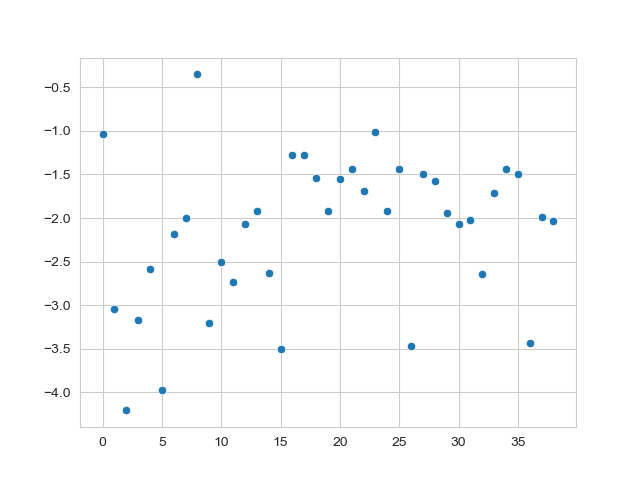

<IPython.core.display.Javascript object>


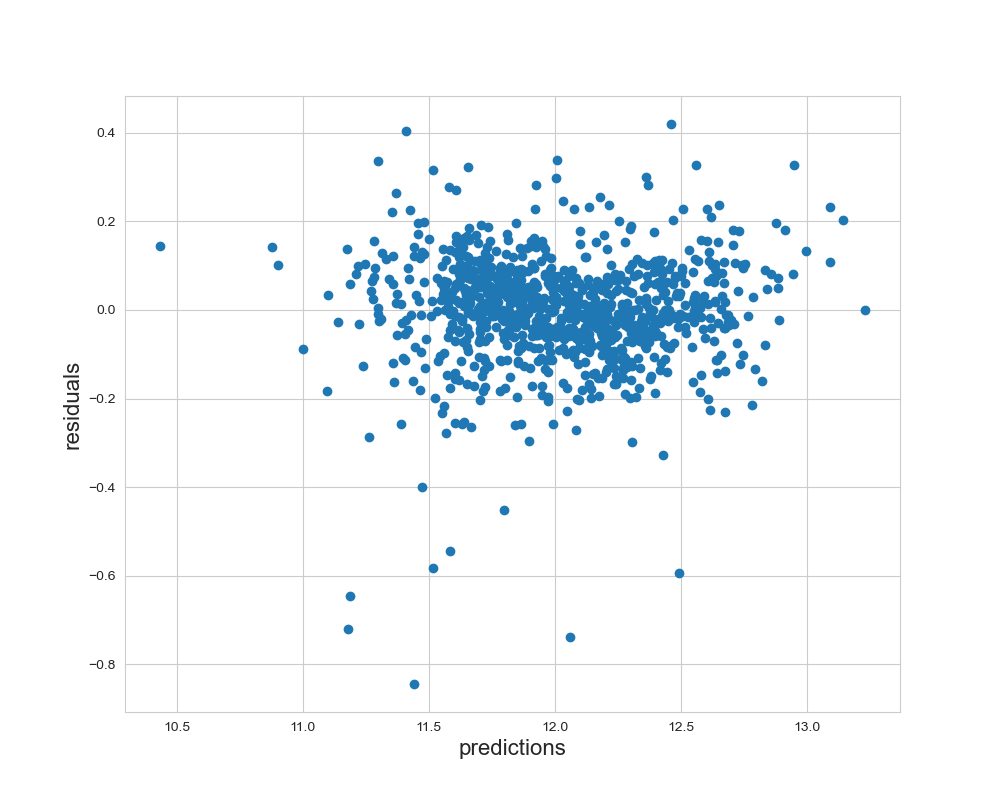

In [15]:
# A plot of the scales of the linear regression coefficients.
log_slr_coef = np.log10(np.abs(slr.coef_))
fig, ax = plt.subplots()
sns.scatterplot(data = log_slr_coef)
plt.show()

plt.figure(figsize=(10,8))


residuals = y_train - y_pred_slr
plt.scatter(y_pred_slr, residuals)


plt.xlabel("predictions", fontsize=16)
plt.ylabel("residuals", fontsize=16)

plt.show()

In [16]:
X = df.drop(columns = 'SalePrice')
y = (df['SalePrice'])
# numeric_train_unbounded = [x for x in numeric_unbounded if x!= 'SalePrice']
# numeric_train = numeric_train_unbounded + numeric_ordinal + cat_ordinal
# X = X[numeric_train]
from sklearn.model_selection import KFold

kfold = KFold(10, shuffle = True, random_state = 69)

mses = np.zeros((2,10))
i = 0

for train_index, test_index in kfold.split(X):
    x_t = X.iloc[train_index]
    y_t = y.iloc[train_index]
    
    x_ho = X.iloc[test_index]
    y_ho = y.iloc[test_index]
    
    pred0 = y_t.mean() * np.ones(len(x_ho))
    
    
    model = LinearRegression(copy_X = True)
    model.fit(x_t,y_t)
    
    pred1 = (model.predict(x_ho))
    
    mses[0,i] = mean_squared_error(np.exp(y_ho),np.exp(pred0), squared = False)
    
    mses[1,i] = mean_squared_error((y_ho),(pred1), squared = False)
    
    i+=1

<IPython.core.display.Javascript object>


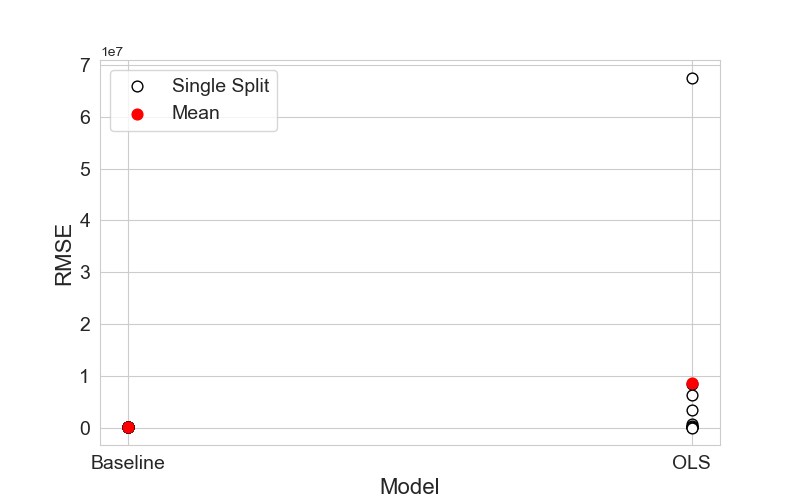

[[7.12770224e+04 7.06499346e+04 6.63446889e+04 8.55072376e+04
  8.51610648e+04 6.36303913e+04 7.08120906e+04 7.84858312e+04
  9.35108116e+04 8.66219083e+04]
 [8.45541905e+06 6.75806697e+07 6.27173755e+05 1.41571694e-01
  1.42876258e-01 2.41347930e+05 1.60747143e+05 1.05208394e-01
  6.20399628e+06 3.37207844e+06]]


In [17]:
plt.figure(figsize=(8,5))

plt.scatter(np.zeros(10), 
            mses[0,:], 
            s=60, 
            c='white',
            edgecolor='black',
            label="Single Split")
plt.scatter(np.ones(10), 
            mses[1,:], 
            s=60, 
            c='white',
            edgecolor='black')

plt.scatter([0,1], np.mean(mses, axis=1), s=60, c='r', label="Mean")

plt.legend(fontsize=14)

plt.xticks([0,1],["Baseline", "OLS"], fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Model", fontsize=16)
plt.ylabel("RMSE", fontsize=16)

plt.show()

(np.mean(mses[1]))
print(mses)

## Ridge Regression
The OLS coefficient blowup is due to the artifically high model complexity and the multicollinearity indtroduced by the one hot encoding of the categorical variables. We can keep them in check by constraining them with lasso,ridge and elastic net regularization models and seeing how they control the coefficients.

In [6]:
#We use gridsearchCV to fit a Ridge Regression model to the data
X = df.drop(columns = 'SalePrice')
y = (df['SalePrice'])

#Import Statements
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler


ridge_pipe = Pipeline([('scale',RobustScaler()),
                              ('ridge',Ridge())])


#Grid Search CV
parameters = {'ridge__alpha': np.logspace(-1, 4, 10)}
ridge_cv = GridSearchCV(ridge_pipe,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_cv.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', RobustScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([1.00000000e-01, 3.59381366e-01, 1.29154967e+00, 4.64158883e+00,
       1.66810054e+01, 5.99484250e+01, 2.15443469e+02, 7.74263683e+02,
       2.78255940e+03, 1.00000000e+04])},
             scoring='neg_mean_squared_error')

In [8]:
print(ridge_cv.best_score_)
print(ridge_cv.best_params_)

-0.012500393561465123
{'ridge__alpha': 16.68100537200059}


# Lasso Estimator

In [9]:
X = df.drop(columns = 'SalePrice')
y = (df['SalePrice'])

from sklearn.linear_model import Lasso

lasso_pipe = Pipeline([('scale',RobustScaler()),
                              ('lasso',Lasso())])

parameters = {'lasso__alpha': np.logspace(-3.5, -1, 10)}
lasso_cv = GridSearchCV(lasso_pipe,parameters,scoring='neg_mean_squared_error',cv=5)
lasso_cv.fit(X,y)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', RobustScaler()),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': array([0.00031623, 0.00059948, 0.00113646, 0.00215443, 0.00408424,
       0.00774264, 0.01467799, 0.02782559, 0.05274997, 0.1       ])},
             scoring='neg_mean_squared_error')

In [11]:
lasso_cv.best_score_
lasso_cv.best_params_

{'lasso__alpha': 0.0005994842503189409}

# Comparison of the Ridge and Lasso Estimators
Here we look at the coefficients of the best Ridge and Lasso estimators.

In [22]:
ridge_estimator = ridge_cv.best_estimator_
lasso_estimator = lasso_cv.best_estimator_

ridge_coefs = ridge_estimator['ridge'].coef_
lasso_coefs = lasso_estimator['lasso'].coef_

In [23]:
ridge_coefs = pd.DataFrame(ridge_coefs.reshape(1,-1), columns = X.columns)
lasso_coefs= pd.DataFrame(lasso_coefs.reshape(1,-1), columns = X.columns)

In [24]:
#Coefficients of the Ridge Regression
print_full(ridge_coefs.T[0].sort_values(ascending = False))

GrLivArea                0.155564
OverallQual              0.103763
Neighborhood_Crawfor     0.072418
TotalBsmtSF              0.059103
Neighborhood_StoneBr     0.049834
Exterior1st_BrkFace      0.047079
LotArea                  0.041224
OverallCond              0.039980
MSZoning_FV              0.038662
BsmtFinSF1               0.038050
Condition1_Norm          0.037101
Neighborhood_NridgHt     0.036401
GarageCars               0.036211
Neighborhood_BrkSide     0.035247
Functional               0.032201
SaleType_New             0.030672
Neighborhood_NoRidge     0.030312
FullBath                 0.029278
HalfBath                 0.028537
MSZoning_RL              0.028373
CentralAir_Y             0.028181
SaleCondition_Normal     0.027273
LotConfig_CulDSac        0.025015
HeatingQC                0.024912
Neighborhood_Somerst     0.024554
BsmtFinType1             0.024391
MSZoning_RH              0.023835
BsmtFullBath             0.023816
KitchenQual              0.023727
TotRmsAbvGrd  

In [25]:
#Coefficients of the Lasso Regression
print_full(lasso_coefs[lasso_coefs != 0].T[0].sort_values(ascending = False))

GrLivArea                1.871183e-01
OverallQual              1.125169e-01
Neighborhood_Crawfor     9.127796e-02
SaleType_New             5.742867e-02
TotalBsmtSF              5.378894e-02
Exterior1st_BrkFace      4.723775e-02
BsmtFinSF1               4.377984e-02
Neighborhood_StoneBr     4.217057e-02
OverallCond              4.123310e-02
Neighborhood_BrkSide     4.069195e-02
GarageCars               3.972817e-02
LotArea                  3.907023e-02
Condition1_Norm          3.880783e-02
Neighborhood_NridgHt     3.708945e-02
Functional               3.130479e-02
HeatingQC                2.655740e-02
KitchenQual              2.550327e-02
Neighborhood_Somerst     2.330686e-02
BsmtFullBath             1.961357e-02
ExterQual                1.652329e-02
BsmtFinType1             1.558084e-02
Foundation_PConc         1.486576e-02
WoodDeckSF               1.341447e-02
BsmtExposure             1.232447e-02
HalfBath                 1.231919e-02
MasVnrType_Stone         1.207451e-02
TotRmsAbvGrd

<IPython.core.display.Javascript object>


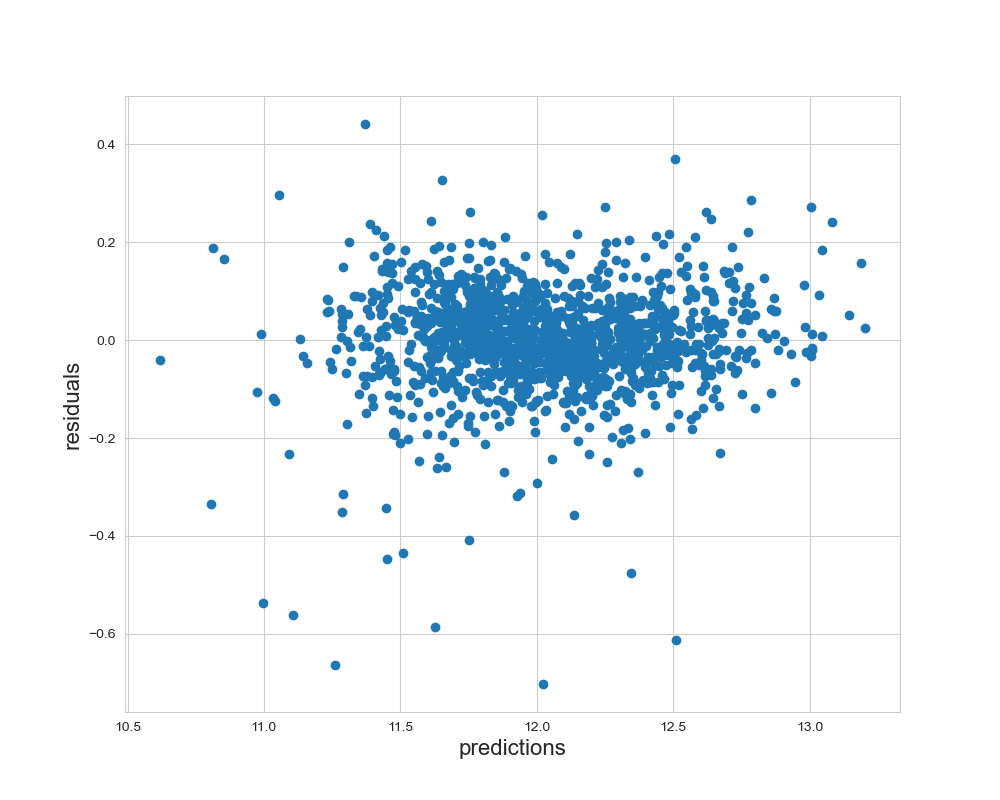

<IPython.core.display.Javascript object>


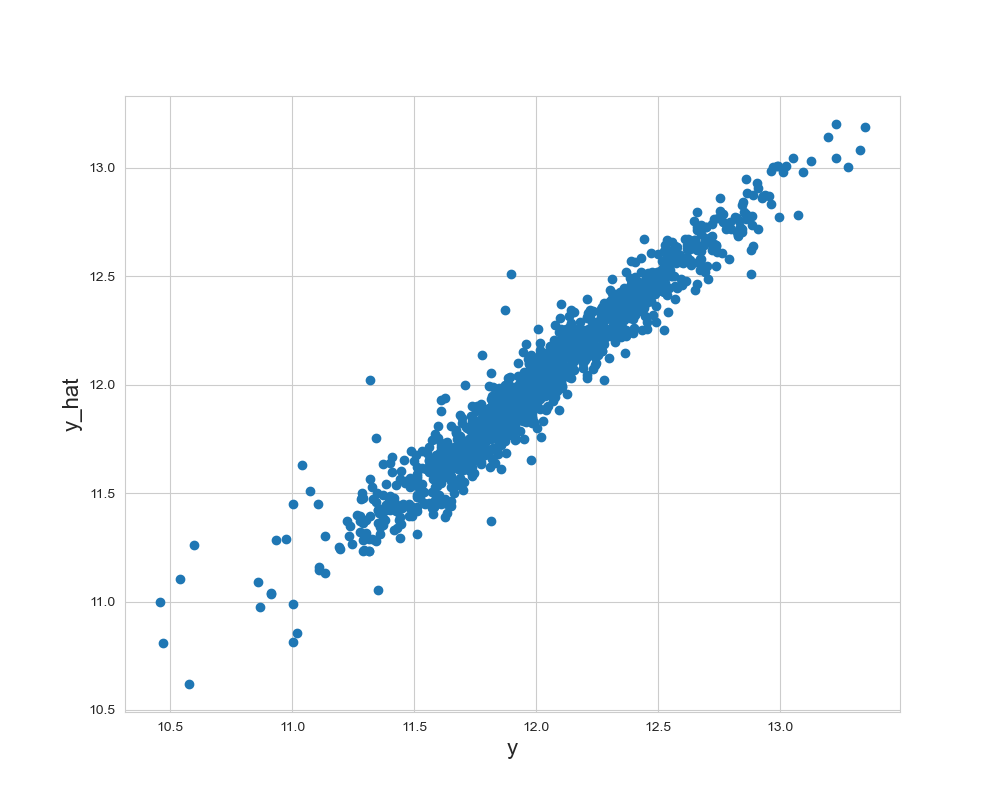

In [26]:
y_hat = ridge_estimator.predict(X)
residuals = y - y_hat

plt.figure(figsize=(10,8))

plt.scatter(y_hat, residuals)


plt.xlabel("predictions", fontsize=16)
plt.ylabel("residuals", fontsize=16)

plt.show()

plt.figure(figsize=(10,8))

plt.scatter(y, y_hat)


plt.xlabel("y", fontsize=16)
plt.ylabel("y_hat", fontsize=16)

plt.show()

<IPython.core.display.Javascript object>


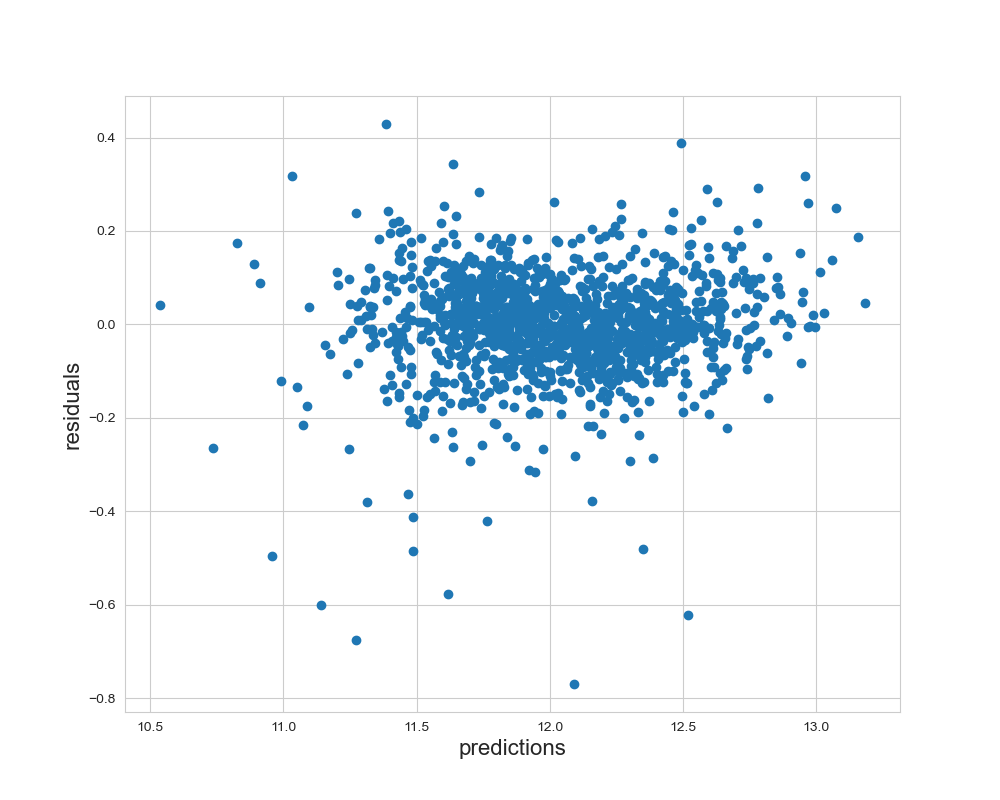

<IPython.core.display.Javascript object>


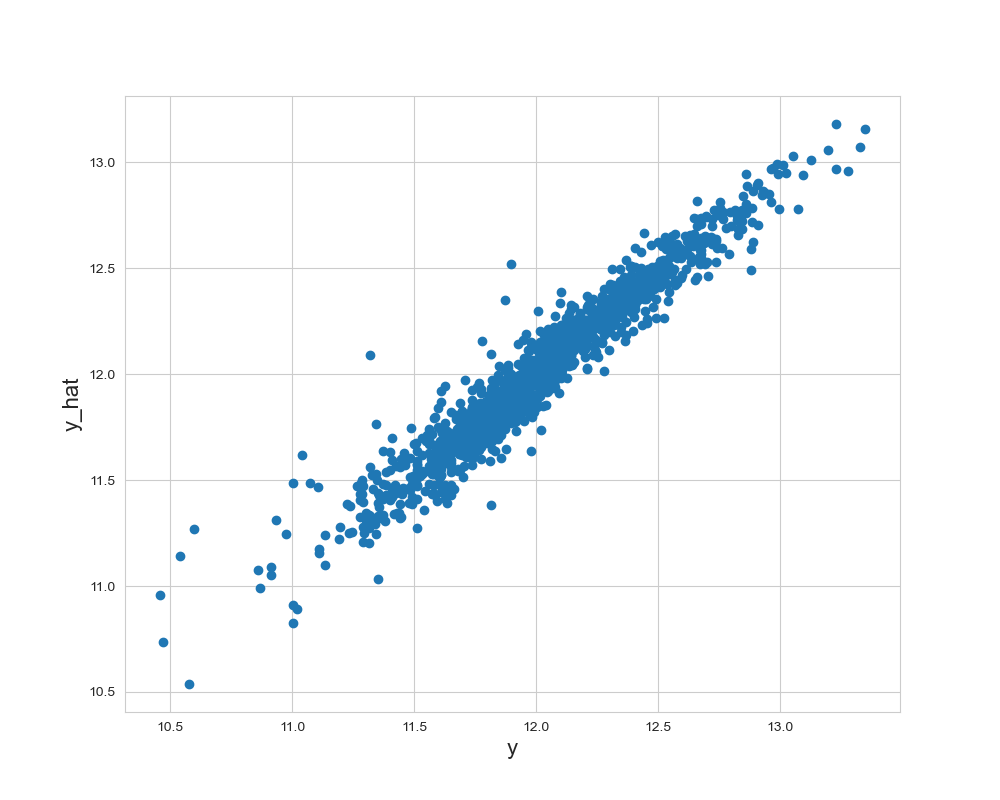

In [27]:
y_hat = lasso_estimator.predict(X)
residuals = y - y_hat

plt.figure(figsize=(10,8))

plt.scatter(y_hat, residuals)
plt.xlabel("predictions", fontsize=16)
plt.ylabel("residuals", fontsize=16)

plt.show()

plt.figure(figsize=(10,8))

plt.scatter(y, y_hat)


plt.xlabel("y", fontsize=16)
plt.ylabel("y_hat", fontsize=16)

plt.show()

## Elastic Net
A mixture of both the lasso and the ridge regression.

In [14]:
X = df.drop(columns = 'SalePrice')
y = (df['SalePrice'])
from sklearn.linear_model import ElasticNet

elastic_pipe = Pipeline([('scale',RobustScaler()),
                              ('elastic',ElasticNet())])
parameters = {'elastic__alpha': np.logspace(-3.5, -1, 10), 'elastic__l1_ratio': [.1, .5, .7, .9, .95, .99,
1]}

elastic_cv = GridSearchCV(elastic_pipe,parameters,scoring='neg_mean_squared_error',cv=5)
elastic_cv.fit(X,y)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', RobustScaler()),
                                       ('elastic', ElasticNet())]),
             param_grid={'elastic__alpha': array([0.00031623, 0.00059948, 0.00113646, 0.00215443, 0.00408424,
       0.00774264, 0.01467799, 0.02782559, 0.05274997, 0.1       ]),
                         'elastic__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99,
                                               1]},
             scoring='neg_mean_squared_error')

In [15]:
elastic_cv.best_score_
elastic_cv.best_params_

{'elastic__alpha': 0.0005994842503189409, 'elastic__l1_ratio': 0.9}

In [65]:
elastic_estimator = elastic_cv.best_estimator_
elastic_coefs = elastic_estimator['elastic'].coef_
elastic_coefs = pd.DataFrame(elastic_coefs.reshape(1,-1), columns = X.columns)
print_full(elastic_coefs[elastic_coefs != 0].T[0].sort_values(ascending = False))

GrLivArea                0.184336
Neighborhood_Crawfor     0.108199
OverallQual              0.105561
Neighborhood_StoneBr     0.084823
Exterior1st_BrkFace      0.058009
Neighborhood_NridgHt     0.057699
Neighborhood_BrkSide     0.055600
TotalBsmtSF              0.051563
Neighborhood_NoRidge     0.043891
OverallCond              0.040223
LotArea                  0.038875
BsmtFinSF1               0.038718
Condition1_Norm          0.038472
GarageCars               0.038346
SaleType_New             0.036347
Functional               0.034434
Neighborhood_Somerst     0.028119
HeatingQC                0.026785
MSZoning_FV              0.023912
LotConfig_CulDSac        0.023613
KitchenQual              0.022583
BsmtFullBath             0.021750
BsmtFinType1             0.021510
HalfBath                 0.019390
FullBath                 0.018667
MasVnrType_Stone         0.018454
TotRmsAbvGrd             0.016503
WoodDeckSF               0.015922
MoSold_May               0.014684
Neighborhood_C

<IPython.core.display.Javascript object>


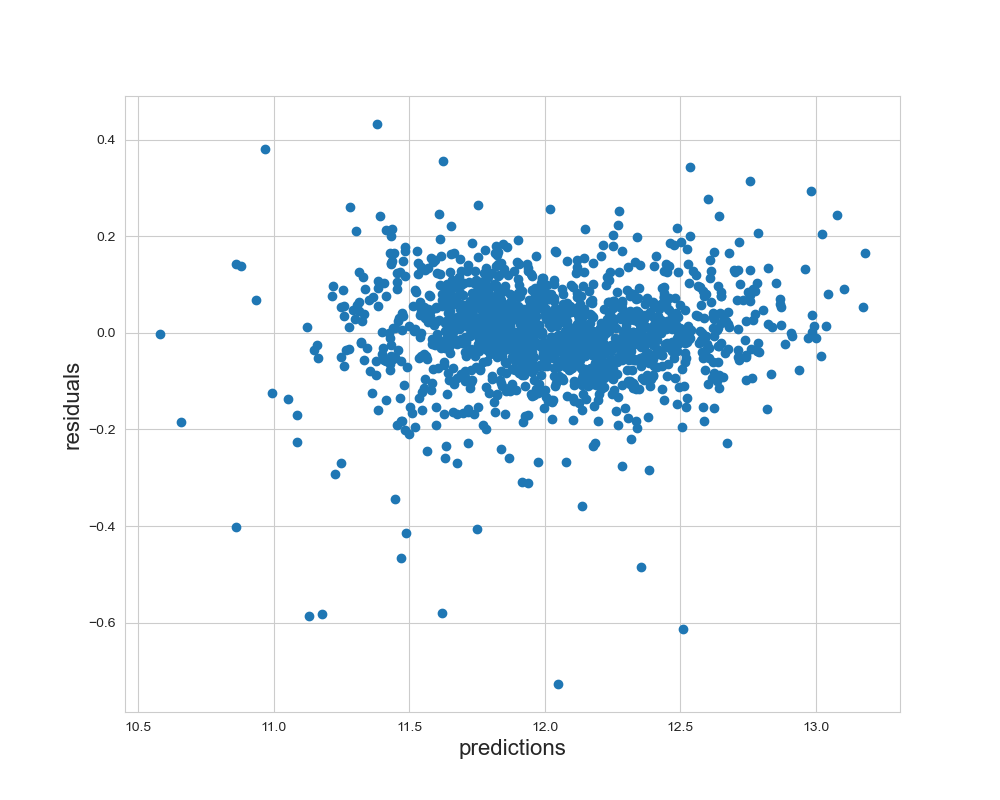

<IPython.core.display.Javascript object>


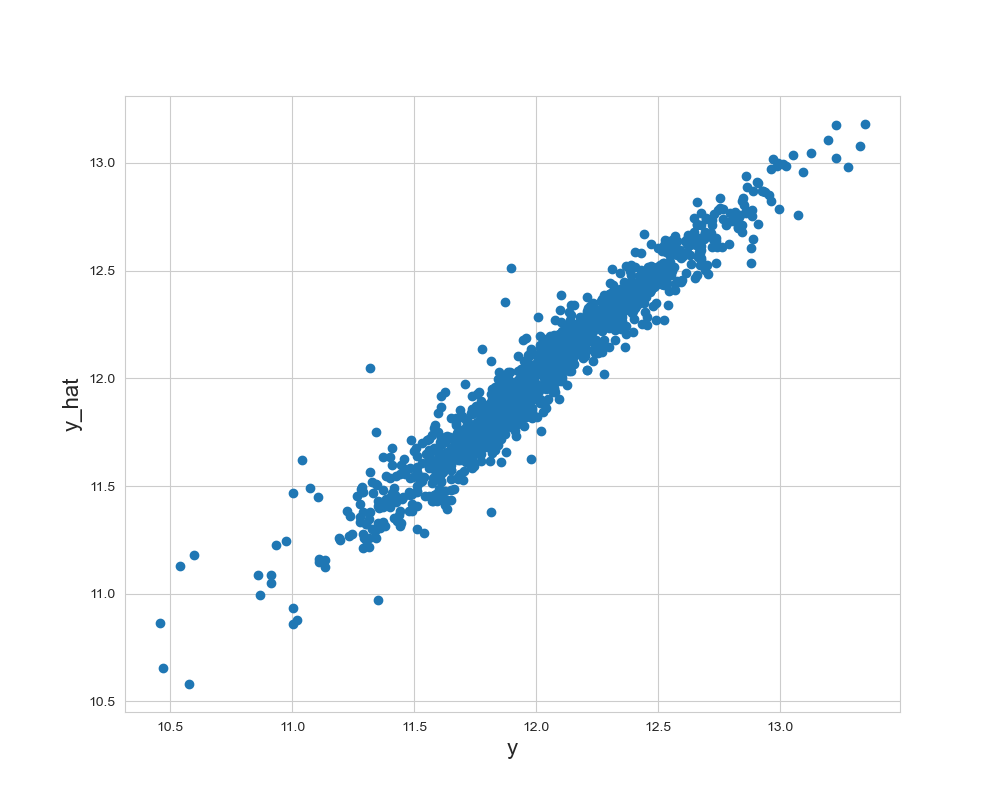

In [66]:
y_hat = elastic_estimator.predict(X)
residuals = y - y_hat

plt.figure(figsize=(10,8))

plt.scatter(y_hat, residuals)


plt.xlabel("predictions", fontsize=16)
plt.ylabel("residuals", fontsize=16)

plt.show()

plt.figure(figsize=(10,8))

plt.scatter(y, y_hat)


plt.xlabel("y", fontsize=16)
plt.ylabel("y_hat", fontsize=16)

plt.show()

In [67]:
#I want to see the coefficients of the best model on every fold.
print(elastic_estimator['elastic'].alpha)
print(elastic_estimator['elastic'].l1_ratio)

0.00046415888336127773
1


## Eliminating all the zero features of elastic net

In [62]:
non_zero = elastic_coefs.loc[:, (elastic_coefs != 0).any(axis=0)]

X = df[non_zero.columns]
y = (df['SalePrice'])

elastic_pipe = Pipeline([('scale',RobustScaler()),
                              ('elastic',ElasticNet())])
parameters = {'elastic__alpha': np.logspace(-4, -1, 10), 'elastic__l1_ratio': [.1, .5, .7, .9, .95, .99,
1]}

elastic_cv_drop = GridSearchCV(elastic_pipe,parameters,scoring='neg_mean_squared_error',cv=5)
elastic_cv_drop.fit(X,y)

print(elastic_cv_drop.best_score_)
print(elastic_cv_drop.best_params_)
elastic_estimator_drop = elastic_cv_drop.best_estimator_
elastic_drop_coefs = elastic_estimator_drop['elastic'].coef_
elastic_drop_coefs = pd.DataFrame(elastic_drop_coefs.reshape(1,-1), columns = X.columns)
print_full(elastic_drop_coefs[elastic_drop_coefs != 0].T[0].sort_values(ascending = False))

-0.011688654666748314
{'elastic__alpha': 0.000774263682681127, 'elastic__l1_ratio': 0.1}
GrLivArea                0.182198
Neighborhood_Crawfor     0.118485
Neighborhood_StoneBr     0.107618
OverallQual              0.101618
Neighborhood_NridgHt     0.069488
Neighborhood_NoRidge     0.065406
Neighborhood_BrkSide     0.063349
Exterior1st_BrkFace      0.055197
TotalBsmtSF              0.047557
Heating_GasW             0.045616
OverallCond              0.039804
LotArea                  0.039031
GarageCars               0.036767
BsmtFinSF1               0.036487
Functional               0.036401
Condition1_Norm          0.035788
LotConfig_CulDSac        0.034527
Exterior2nd_Wd Sdng      0.034205
MSZoning_FV              0.033613
Neighborhood_ClearCr     0.033153
BsmtFinType2_ALQ         0.030048
Neighborhood_Somerst     0.028177
HeatingQC                0.026936
FullBath                 0.026295
BsmtFinType1             0.026288
HalfBath                 0.026092
MasVnrType_Stone         0.

In [45]:
X = df.drop(columns = 'SalePrice')
y = (df['SalePrice'])
from sklearn.model_selection import KFold
kfold = KFold(5, shuffle = True, random_state = 69)

elastic_coefs = np.empty((5,X.shape[1]))
i = 0

for train_index, test_index in kfold.split(X):
    x_t = X.iloc[train_index]
    y_t = y.iloc[train_index]
    
    x_ho = X.iloc[test_index]
    y_ho = y.iloc[test_index]    
    
    elastic_pipe = Pipeline([('scale',RobustScaler()),
                              ('elastic',ElasticNet(alpha = .00077, l1_ratio = 0.7))])
    elastic_pipe.fit(x_t,y_t)
    elastic_coefs[i,:] = elastic_pipe['elastic'].coef_
    
    i+=1

In [46]:
elasticdf = pd.DataFrame(elastic_coefs, columns = X.columns)

In [47]:
coefsum = elasticdf.sum(axis = 'rows')
coefsum[coefsum != 0].index

Index(['MoSold_Apr', 'MoSold_Aug', 'MoSold_Dec', 'MoSold_Jul', 'MoSold_Jun',
       'MoSold_Mar', 'MoSold_May', 'MoSold_Nov', 'MoSold_Oct', 'MoSold_Sep',
       ...
       'TotalBsmtSF', 'LowQualFinSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'Age', 'AgeRemodel'],
      dtype='object', length=142)

In [48]:
non_zero = coefsum[coefsum != 0].index
X = df[non_zero]
y = (df['SalePrice'])

In [49]:
elastic_pipe = Pipeline([('scale',RobustScaler()),
                              ('elastic',ElasticNet())])
parameters = {'elastic__alpha': np.logspace(-4, 0, 10), 'elastic__l1_ratio': [.1, .5, .7, .9, .95, .99,
1]}

elastic_cv = GridSearchCV(elastic_pipe,parameters,scoring='neg_mean_squared_error',cv=7)
elastic_cv.fit(X,y)


GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('scale', RobustScaler()),
                                       ('elastic', ElasticNet())]),
             param_grid={'elastic__alpha': array([1.00000000e-04, 2.78255940e-04, 7.74263683e-04, 2.15443469e-03,
       5.99484250e-03, 1.66810054e-02, 4.64158883e-02, 1.29154967e-01,
       3.59381366e-01, 1.00000000e+00]),
                         'elastic__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99,
                                               1]},
             scoring='neg_mean_squared_error')

In [50]:
print(elastic_cv.best_score_)
print(elastic_cv.best_params_)
elastic_estimator = elastic_cv.best_estimator_
elastic_coefs = elastic_estimator['elastic'].coef_
elastic_coefs = pd.DataFrame(elastic_coefs.reshape(1,-1), columns = X.columns)
print_full(elastic_coefs[elastic_coefs != 0].T[0].sort_values(ascending = False))

-0.011851731025826932
{'elastic__alpha': 0.0002782559402207126, 'elastic__l1_ratio': 1}
GrLivArea                1.828746e-01
Neighborhood_Crawfor     1.147373e-01
OverallQual              1.024685e-01
Neighborhood_StoneBr     9.748753e-02
Neighborhood_NridgHt     6.262713e-02
Neighborhood_BrkSide     6.183547e-02
Exterior1st_BrkFace      6.143396e-02
Neighborhood_NoRidge     5.420379e-02
TotalBsmtSF              5.006794e-02
OverallCond              3.979783e-02
LotArea                  3.943050e-02
Condition1_Norm          3.909743e-02
GarageCars               3.755541e-02
BsmtFinSF1               3.732623e-02
Functional               3.553069e-02
MSZoning_FV              2.975024e-02
LotConfig_CulDSac        2.809099e-02
HeatingQC                2.689158e-02
Heating_GasW             2.658020e-02
Neighborhood_Somerst     2.629910e-02
SaleType_New             2.429801e-02
BsmtFinType1             2.379539e-02
Neighborhood_ClearCr     2.358425e-02
HalfBath                 2.287633e-02


In [51]:
y_hat = elastic_estimator.predict(X)
print(mean_squared_error(np.exp(y),np.exp(y_hat), squared = False))

18433.136066901217


# Ensembling

In [ ]:
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
X = df.drop(columns = 'SalePrice')
y = (df['SalePrice'])


model_xgb.fit(X, y)
xgb_train_pred = model_xgb.predict(train)

# Further Ideas/Comments
- Introduce interaction terms between the top k most important features which are numeric and categorical after elastic net selection. (Regression after elastic net selection seems to do a good job?).
- For some reason after I introduced the skew the forest stopped working?
- Check out the boosted tree models, and ensemble them with the linear regression models